In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import cv2
import numpy as np
import dataset.icdar2015_loader as ic15
from PIL import Image
from torchvision.transforms import transforms
import pdb
import torch

data_dir = ic15.ic15_train_data_dir
gt_dir   = ic15.ic15_train_gt_dir

get_img  = ic15.get_img

IMG_SIZE = (640, 640)
KERNEL_NUM = 7
MIN_SCALE = 0.4

def show_np_img(img):
    if isinstance(img, list):
        print('list of img. len=', len(img))
        for im in img:
            show_np_img(im)
        return
            
    if isinstance(img, torch.Tensor):
        img = img.cpu().detach().numpy()
        img = img*255
        if img.ndim == 3:
            img = np.transpose(img, [1,2,0]) # (c, h, w) -> (h, w, c)
        
    print(type(img.shape), img.shape)#, img[0][:10])
    h, w = img.shape[:2]
    rcParams['figure.figsize'] = max(h/150, 10), max(w/150, 10)
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    elif img.ndim == 3:
        plt.imshow(img)
    else:
        raise f'{img.ndim} is invalid'
    plt.show()
torch.__version__

'1.1.0'

In [75]:
from pathlib import Path

g_img_names = [f.name for f in Path(data_dir).iterdir() if f.name.endswith('.jpg') or f.name.endswith('.png')]

g_img_paths = []
g_gt_paths = []
for idx, img_name in enumerate(g_img_names):
    img_path = data_dir + img_name
    g_img_paths.append(img_path)
    
    gt_name = 'gt_' + img_name.split('.')[0] + '.txt'
    gt_path = gt_dir + gt_name
    g_gt_paths.append(gt_path)

In [93]:
'''
리턴값:
    img: 원본 이미지
    gt_text: 텍스트 박스 내부는 하얀색(1) 배경은 검은색(0)
    trainning_mask: 
        don't care 는 검은색(0)으로 처리하여 
        훈련에서 제외시킨다.
    
drawContours(img, contours, idx, color, thickness)
    contours = [contour_1, contours_2, ..., contours_n] 
    contour_i = [point_1, point_2, ... point_k]
    point_i = [x, y]
    if idx == -1 이면 모든 contour_i 다 그리기 
    gray 이미지에 대해서는 color 가 0.5 이상이냐 이하냐로 바이너리로 그림
    내부를 꽉 채워서 그림
kernel:
    KERNEL_NUM = 7 이지만 1부터라 6개만 생성
    shrink_rates = np.linspace(0.4, 1.0, 7)[:-1]
    
'''
def getitem(index):
    
    # 파일 경로. 이미지, 라벨
    img_path = g_img_paths[index]
    gt_path  = g_gt_paths[index]
    
    img = get_img(img_path)
    bboxes, tags = ic15.get_bboxes(img, gt_path)
    
    img = ic15.random_scale(img, 640)
    
    gt_text       = np.zeros(img.shape[0:2], dtype='uint8')
    training_mask = np.ones(img.shape[0:2], dtype='uint8')
    
    if bboxes.shape[0] > 0:
        bboxes = np.reshape(bboxes * ([img.shape[1], img.shape[0]] * 4), (bboxes.shape[0], int(bboxes.shape[1] / 2), 2)).astype('int32')
        for i in range(bboxes.shape[0]):
            cv2.drawContours(gt_text, [bboxes[i]], -1, 1, -1)
            if not tags[i]:
                cv2.drawContours(training_mask, [bboxes[i]], -1, 0, -1)
                
    gt_kernels = []
    #for i in range(1, KERNEL_NUM):
        #rate = (1.0 - (1.0 - MIN_SCALE) / (KERNEL_NUM - 1) * i)
    for rate in np.linspace(MIN_SCALE, 1.0, KERNEL_NUM)[:-1]:
        gt_kernel = np.zeros(img.shape[0:2], dtype='uint8')
        kernel_bboxes = ic15.shrink(bboxes, rate)
        for i in range(bboxes.shape[0]):
            cv2.drawContours(gt_kernel, [kernel_bboxes[i]], -1, 1, -1)
        gt_kernels.append(gt_kernel)

    imgs = [img, gt_text, training_mask]
    imgs.extend(gt_kernels)

    # transform: flip, rotate, crop
    #imgs = ic15.random_horizontal_flip(imgs)
    imgs = ic15.random_rotate(imgs)
    imgs = ic15.random_crop(imgs, IMG_SIZE)

    img, gt_text, training_mask, gt_kernels = imgs[0], imgs[1], imgs[2], imgs[3:]
    
    gt_text[gt_text > 0] = 1             # binarize
    gt_kernels = np.array(gt_kernels)    # to numpy
    print('gt_kernels:', gt_kernels.shape)
    
        
    #transform: color
    np_img = img.copy()
    img = Image.fromarray(img)
    img = img.convert('RGB')
    img = transforms.ColorJitter(brightness = 32.0 / 255, saturation = 0.5)(img)
    
    
    img = transforms.ToTensor()(img) # 255->1.0,  (h, w, c) => (c, h, w)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)

    # numpy to tensor
    gt_text    = torch.from_numpy(gt_text).float()
    gt_kernels = torch.from_numpy(gt_kernels).float()
    
    return img, gt_text, training_mask, gt_kernels, np_img 

gt_kernels: (6, 640, 640)
<class 'tuple'> (640, 640, 3)


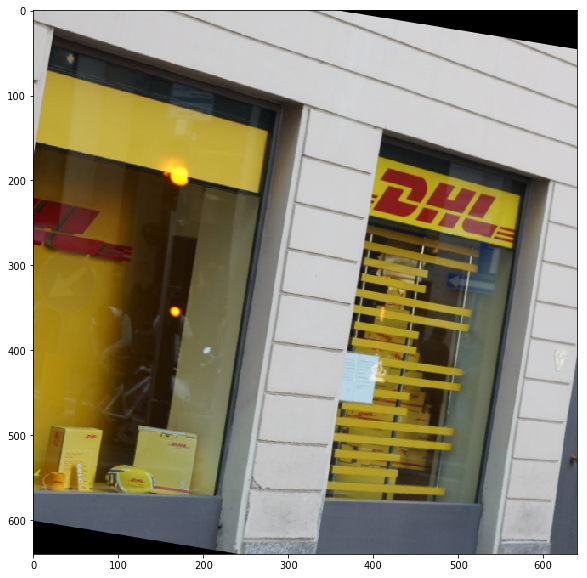

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tuple'> (640, 640, 3)


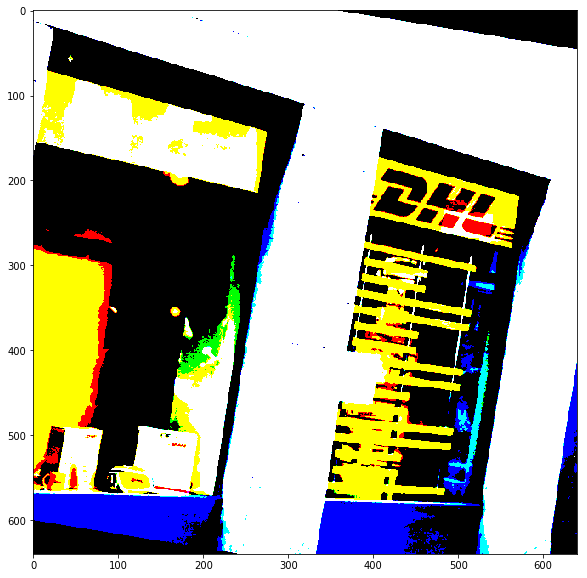

<class 'tuple'> (640, 640)


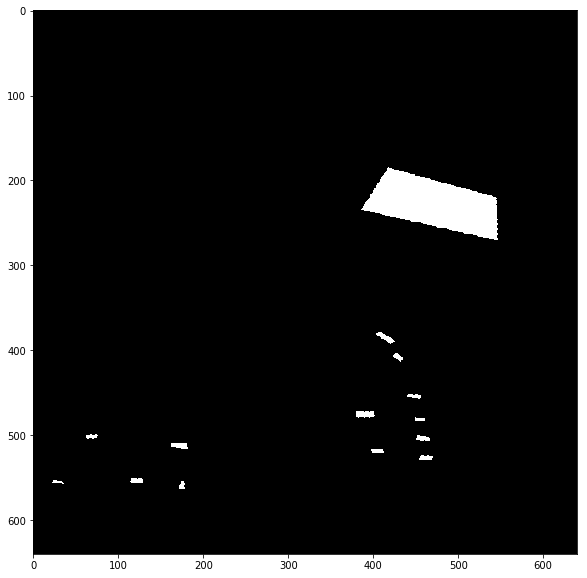

<class 'tuple'> (640, 640)


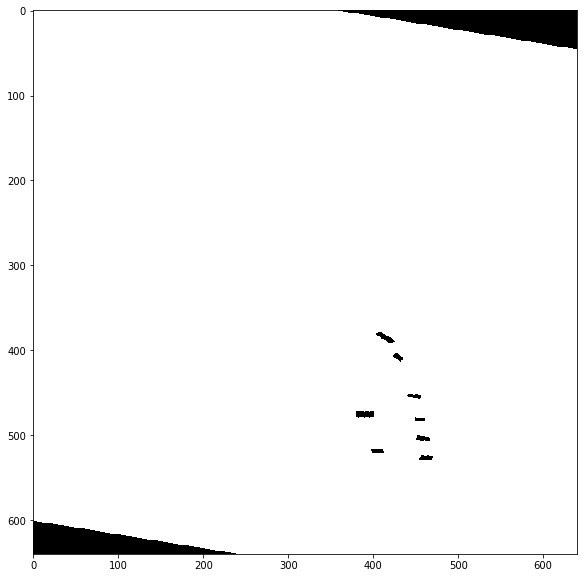

<class 'tuple'> (640, 640)


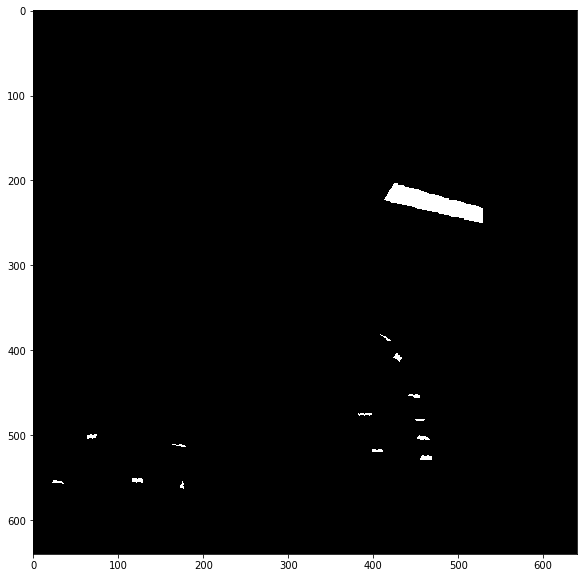

<class 'tuple'> (640, 640)


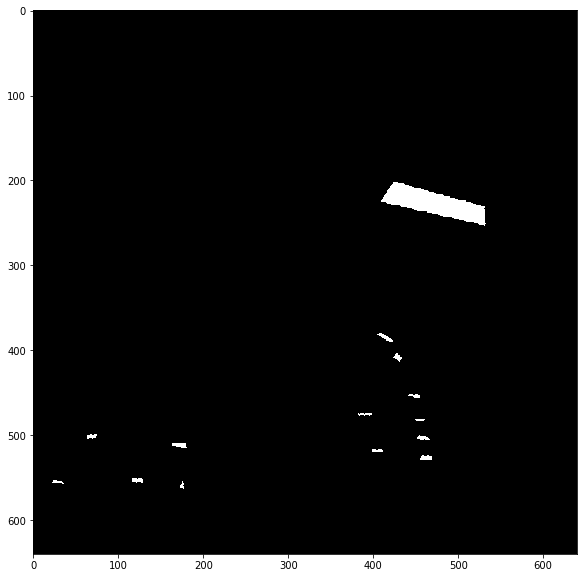

<class 'tuple'> (640, 640)


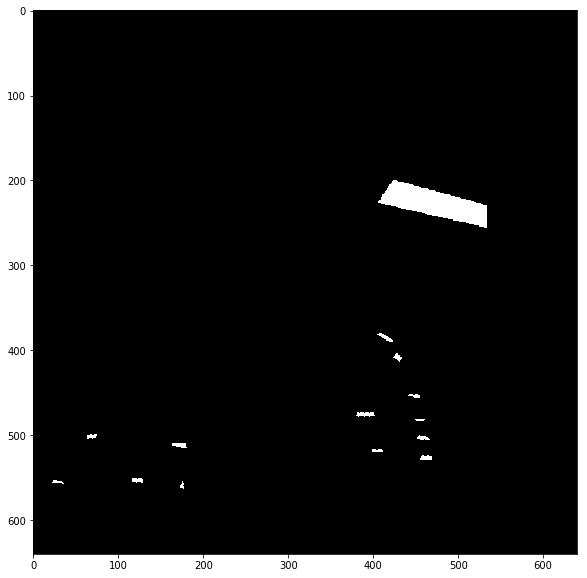

<class 'tuple'> (640, 640)


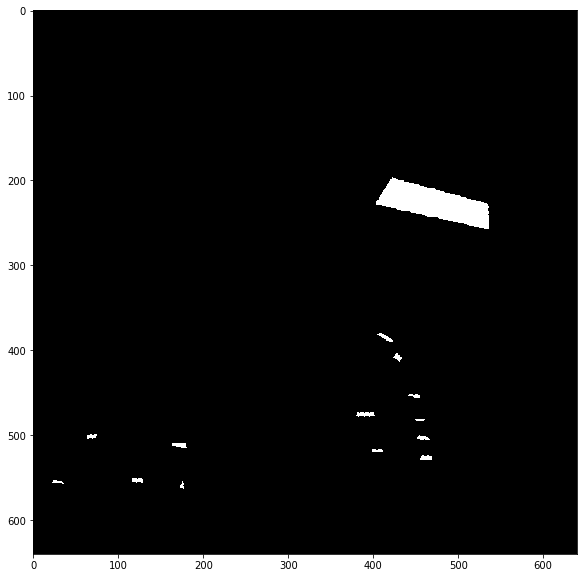

<class 'tuple'> (640, 640)


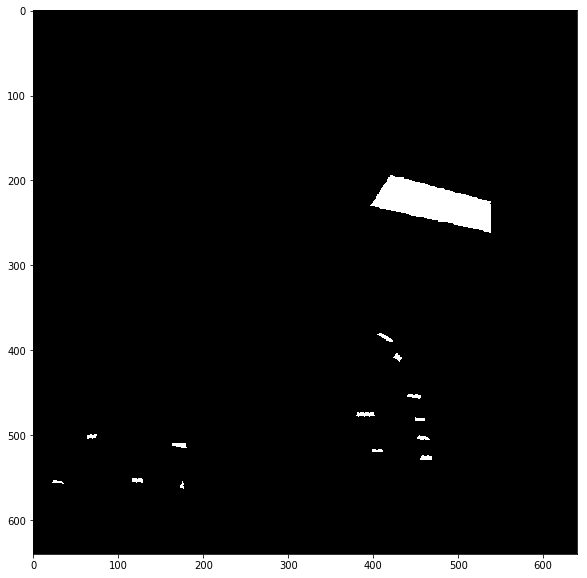

<class 'tuple'> (640, 640)


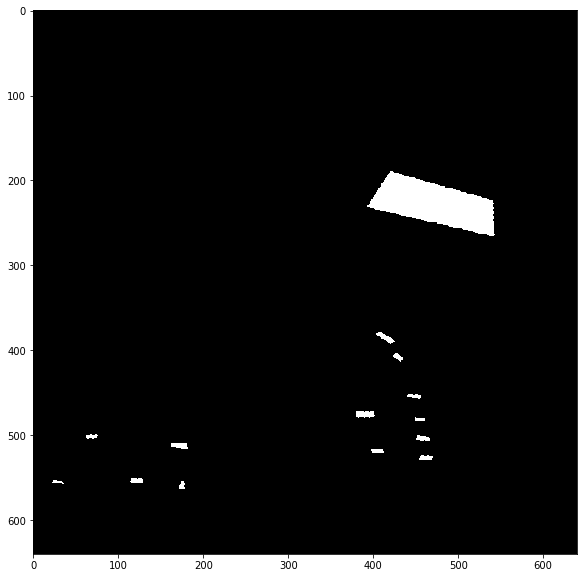

[None, None, None, None, None, None]

In [94]:
img, gt_t, tm, gks, np_img = getitem(123)
show_np_img(np_img)
show_np_img(img)
show_np_img(gt_t)
show_np_img(tm)
[show_np_img(i) for i in gks]

In [92]:
np.linspace(0.4, 1.0, 7)[:-1]

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [6]:
a = 'aab'
a.endswith('ab')

True